In [1]:
import os, sys
sys.path.insert(1, os.path.abspath("../../../"))  # for dowhy source code

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=0, num_effect_modifiers=2,
                                    treatment_is_binary=False)
df=data['df']
df.head()

,X0,X1,W0,W1,W2,W3,v,y
0,0.145225,-1.759546,1.918293,-0.759980,-1.267867,1.651874,4.412976,46.446342
1,-2.690032,-0.512667,0.526296,2.044416,0.501536,0.934371,9.259727,93.770702
2,0.850353,1.631275,-1.299425,0.366986,-1.183831,3.680427,-2.923456,-17.623796
3,-0.406601,0.717595,-0.387795,-1.259225,-0.488911,0.734366,-4.307275,-49.475401
4,-0.384311,1.097385,-0.233668,-0.437109,-0.773949,0.261197,-3.937221,-43.550981


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v'] on outcome ['y']


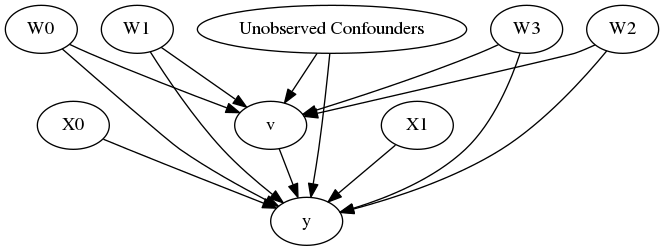

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W3', 'W0', 'W1', 'W2', 'Unobserved Confounders']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W3,W0,W1,W2))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W3,W0,W1,W2,U) = P(y|v,W3,W0,W1,W2)



In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCate",
                                 target_units = lambda df: df["X0"]>2, 
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W3+W0+W1+W2


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
No such variable found!
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W3,W0,W1,W2))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W3,W0,W1,W2,U) = P(y|v,W3,W0,W1,W2)

## Realized estimand
b: y~v+W3+W0+W1+W2
## Estimate
Value: 11.192554049175103



## Refuting the estimate

### Random 

In [8]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W3+W0+W1+W2+w_random


Refute: Add a Random Common Cause
Estimated effect:(11.192554049175103,)
New effect:(11.170230405137357,)



### Adding an unobserved common cause variable

In [9]:
res_unobserved=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W3+W0+W1+W2


Refute: Add an Unobserved Common Cause
Estimated effect:(11.192554049175103,)
New effect:(10.943509230361029,)



#### Replacing treatment with a random (placebo) variable

In [10]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W3+W0+W1+W2


Refute: Use a Placebo Treatment
Estimated effect:(11.192554049175103,)
New effect:(0.39436059715270927,)



#### Removing a random subset of the data

In [11]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.8)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W3+W0+W1+W2


Refute: Use a subset of data
Estimated effect:(11.192554049175103,)
New effect:(11.19403806452647,)

